In [1]:
from pymongo import MongoClient
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Connect to db collections
client = MongoClient('mongodb://localhost:27017/')
db = client['address-clustering']
transfers = db['transfers']
transactions = db['transactions']

In [87]:
# specify the address you want to search for
addresses = ["0x85e5472752a6f00775faca4d5179bde1081571b0", "0xbf886e3069d0dfd64e384c93da322f775faa8876"]
addresses = [address.lower() for address in addresses]
#0xb4955ba9d1fda0c45e1eaa9c5c103d79b9622413

# create the query
query = { "$or": [ { "from": { "$in": addresses } }, { "to": { "$in": addresses } } ] }

# perform the query on the 'transactions' collection
transactions_df = pd.DataFrame(list(transactions.find(query)))
transfers_df = pd.DataFrame(list(transfers.find(query)))
all = pd.concat([transfers_df,transactions_df], ignore_index=True)
all_grouped = all.groupby(['from', 'to']).size().reset_index(name='weight')
all_grouped

,from,to,weight
0,0x0000000000000000000000000000000000000000,0x85e5472752a6f00775faca4d5179bde1081571b0,119
1,0x0000000000000000000000000000000000000000,0xbf886e3069d0dfd64e384c93da322f775faa8876,114
2,0x0035e850c19adabb754e6c82b513a86daea8e77d,0xbf886e3069d0dfd64e384c93da322f775faa8876,1
3,0x019ba0325f1988213d448b3472fa1cf8d07618d7,0xbf886e3069d0dfd64e384c93da322f775faa8876,1
4,0x075e72a5edf65f0a5f44699c7654c1a76941ddc8,0xbf886e3069d0dfd64e384c93da322f775faa8876,3
...,...,...,...
393,0xf5962dd1cfb95bd15a598b721091b373fcf1e3d1,0x85e5472752a6f00775faca4d5179bde1081571b0,2
394,0xfb307183c8a80b0facc714e4e8ac3334cb729fd9,0xbf886e3069d0dfd64e384c93da322f775faa8876,1
395,0xfeb3789a1a0f84b9860bab610a3e76ccbc60e43a,0xbf886e3069d0dfd64e384c93da322f775faa8876,1
396,0xfed25267df17bfab23a1f8a26802674769d28c7b,0xbf886e3069d0dfd64e384c93da322f775faa8876,1


In [76]:
address = '0x85e5472752a6f00775faca4d5179bde1081571b0'
df1 = pd.read_csv('../data/token_transfers.csv')
df2 = pd.read_csv('../data/native_transfers.csv')
df = pd.concat([df1, df2], ignore_index=True)
df = df.loc[(df['from'] == address) | (df['to'] == address)]
df = df.groupby(['from','to']).size().reset_index(name='weight')
df

,from,to,weight
0,0x85e5472752a6f00775faca4d5179bde1081571b0,0x85e5472752a6f00775faca4d5179bde1081571b0,3
1,0x85e5472752a6f00775faca4d5179bde1081571b0,0x88004441a0f79727d19a2697344244c901736e0a,1
2,0x85e5472752a6f00775faca4d5179bde1081571b0,0x8fa33056d9067ba93bc89a3366aad64952743028,1
3,0x85e5472752a6f00775faca4d5179bde1081571b0,0xb08f95dbc639621dbaf48a472ae8fce0f6f56a6e,14
4,0x8fa33056d9067ba93bc89a3366aad64952743028,0x85e5472752a6f00775faca4d5179bde1081571b0,1
5,0xb08f95dbc639621dbaf48a472ae8fce0f6f56a6e,0x85e5472752a6f00775faca4d5179bde1081571b0,7
6,0xb7d3a787a39f25457ca511dc3f0591b546f5e02f,0x85e5472752a6f00775faca4d5179bde1081571b0,1
7,0xbf886e3069d0dfd64e384c93da322f775faa8876,0x85e5472752a6f00775faca4d5179bde1081571b0,3


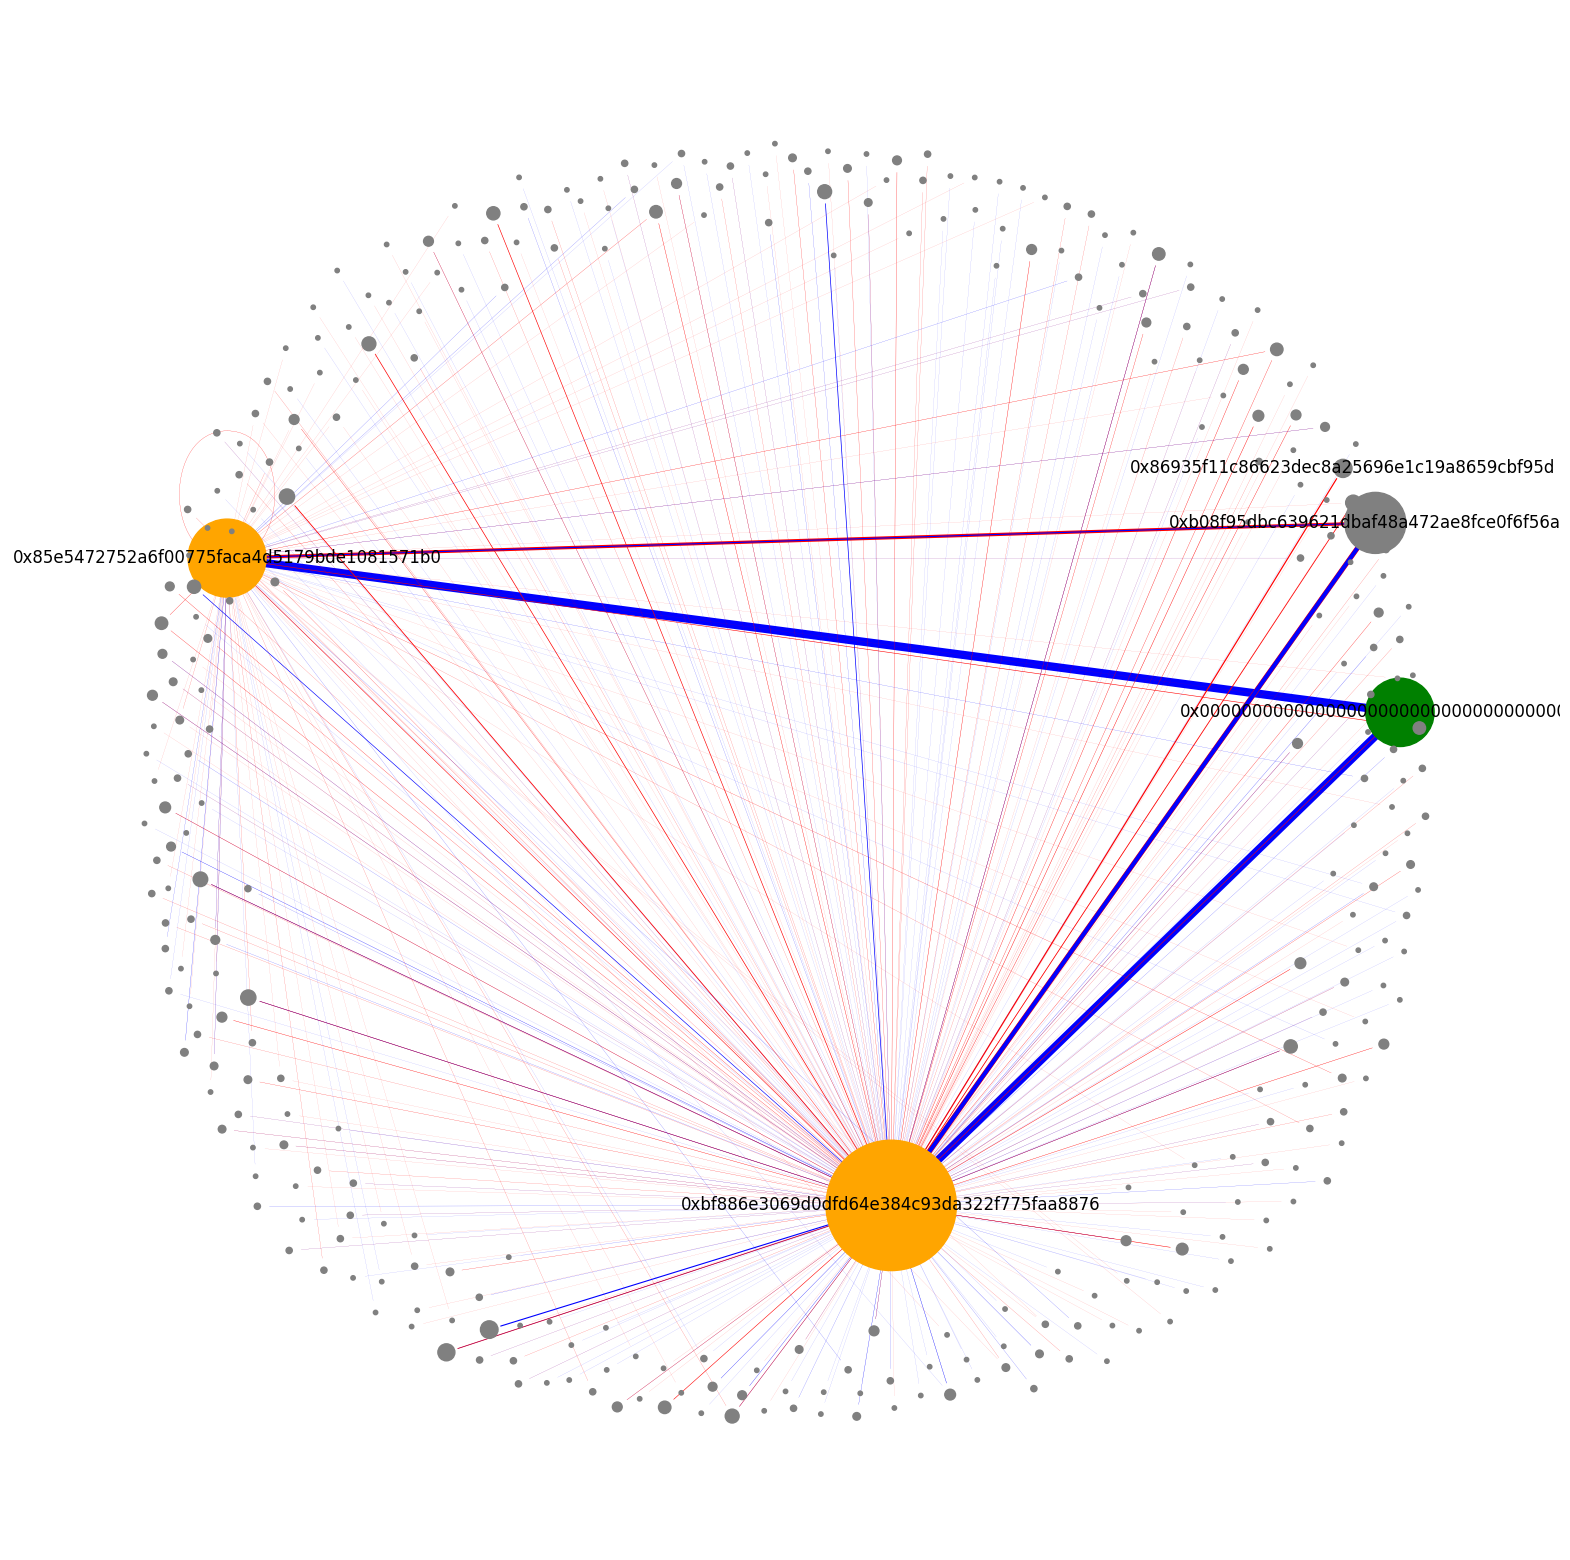

In [91]:
# Graph
G = nx.from_pandas_edgelist(all_grouped, 'from', 'to', edge_attr='weight', create_using=nx.MultiDiGraph())

# Position layout
pos = nx.spring_layout(G, scale = 100, k= 5)
#pos = nx.kamada_kawai_layout(G, scale=50)

fig, ax = plt.subplots(figsize=(20, 20))

# Nodes
## Color
color_map = []
for node in G:
    if node in addresses:
        color_map.append('orange')
    elif node == '0x0000000000000000000000000000000000000000':
        color_map.append('green')
    else:
        color_map.append('grey')
## Size
# node_size = [v * 1.1 for v in dict(G.degree).values()]
# nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=node_size, ax=ax)
node_size = [v * 10 for v in dict(G.degree(weight='weight')).values()]
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=node_size, ax=ax)


# Edges
## Color
edge_colors = ['red' if u in addresses else 'blue' for u, v in G.edges()]
## Size
edge_widths = [0.05 * data.get('weight', 1) for u, v, data in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=1, ax=ax, arrowstyle="-")


# Labels
degree_weight = dict(G.degree(weight='weight'))
sorted_nodes = sorted(degree_weight.items(), key=lambda x: x[1], reverse=True)
top_nodes = [n for n, d in sorted_nodes[:5]]
labels = {node: node for node in top_nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_color='black', ax=ax)


plt.axis('off')
plt.savefig("../figures/network_visualization.png", dpi=500, transparent=False)
plt.show()